<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%94%D0%BE%D0%BF%D0%BE%D0%BB%D0%BD%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C_OpenCV_%D1%81%D0%BE%D0%B2%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5_%D1%84%D0%BE%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D1%84%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дополненная реальность OpenCV
# OpenCV Augmented Reality (AR)

В этом уроке вы изучите основы дополненной реальности с помощью OpenCV.
Как и в уроках о маркерах ArUco , наша цель - обнаружить каждый из четырех тегов ArUco, отсортировать их в верхнем левом, верхнем правом, нижнем левом и нижнем правом порядке, а затем применить дополненную реальность с помощью преобразования исходного изображения на карту Pantone.
Как только мы обнаружим нашу поверхность, мы будем использовать OpenCV для преобразования каждого из исходных изображений на карту.


In this tutorial, you will learn the basics of augmented reality using OpenCV.
As with the ArUco markers tutorials, our goal is to discover each of the four ArUco tags, sort them in top-left, top-right, bottom-left, and bottom-right order, and then apply augmented reality by transforming the original image to a Pantone map.
Once we find our surface, we will use OpenCV to convert each of the original images to a map.



Чтобы повторить эксперимент с дополненной реальностью, распечатайте файл с отсканированной картой Pantone, вырежьте ее и поместите в поле зрения камеры.


To repeat the augmented reality experiment, print the scanned Pantone map file, cut it out, and place it in the camera's field of view.


### Загрузка файлов
### Download the code zip file



In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_17.opencv_augmented_reality.zip
!unzip -qq Lesson_17.opencv_augmented_reality.zip
%cd /content/Lesson_17.opencv_augmented_reality/

--2022-02-12 10:22:50--  http://dataudt.ru/datasets/cv/Lesson_17.opencv_augmented_reality.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16556917 (16M) [application/zip]
Saving to: ‘Lesson_17.opencv_augmented_reality.zip’

Lesson_17.opencv_au 100%[===================>]  15.79M  11.5MB/s    in 1.4s    

2022-02-12 10:22:52 (11.5 MB/s) - ‘Lesson_17.opencv_augmented_reality.zip’ saved [16556917/16556917]

/content/Lesson_17.opencv_augmented_reality



### Импорт библиотек 
### Import Packages

In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

### Функция отображения изображений в Jupyter Notebooks и Google Colab
### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(10,10))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Реализация дополненной реальности с OpenCV
### Implementing augmented reality with OpenCV

In [4]:

# явно укажем аргументы необходимые для работы
# image - путь к входному изображению, содержащему тег ArUCo
# source - путь к исходному изображению, которое будет помещено на вход

# explicitly specify the arguments needed to work
# image - path to input image containing ArUCo tag
# source -  path to input source image that will be put on input
args = {
    "image": "examples/1.jpg",
    "source": "sources/space.jpg"
}

In [5]:
# загружаем входное изображение с диска, изменяем его размер и получаем его размерность
# load the input image from disk, resize it, and grab its spatial
# dimensions
print("[INFO] loading input image and source image...")
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)
(imgH, imgW) = image.shape[:2]

# загружаем исходное изображение с диска
# load the source image from disk
source = cv2.imread(args["source"])

[INFO] loading input image and source image...


In [6]:
# загружаем словарь ArUCo, находим параметры и маркеры
# load the ArUCo dictionary, grab the ArUCo parameters, and detect
# the markers
print("[INFO] detecting markers...")
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
arucoParams = cv2.aruco.DetectorParameters_create()
(corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict,
	parameters=arucoParams)

# если мы не нашли четыре маркера во входном изображении, то мы не сможем
# применить нашу технику дополненной реальности
# if we have not found four markers in the input image then we cannot
# apply our augmented reality technique
if len(corners) != 4:
	print("[INFO] could not find 4 corners...exiting")

[INFO] detecting markers...


In [7]:
# если мы нашли четыре маркера ArUco, то можем продолжить
# разворачивание списка идентификаторов ArUco и инициализацию нашего списка
# контрольных точек
# otherwise, we've found the four ArUco markers, so we can continue
# by flattening the ArUco IDs list and initializing our list of
# reference points
print("[INFO] constructing augmented reality visualization...")
ids = ids.flatten()
refPts = []

# перебираем все идентификаторы маркеров ArUco в верхнем левом, верхнем правом,
# нижнем правом и нижнем левом углах
# loop over the IDs of the ArUco markers in top-left, top-right,
# bottom-right, and bottom-left order
for i in (923, 1001, 241, 1007):
    # берем индекс угла с текущим идентификатором и добавляем его
	# (x, y) координаты в наш список контрольных точек
	# grab the index of the corner with the current ID and append the
	# corner (x, y)-coordinates to our list of reference points
	j = np.squeeze(np.where(ids == i))
	corner = np.squeeze(corners[j])
	refPts.append(corner)

[INFO] constructing augmented reality visualization...


In [8]:
# распаковываем наши контрольные точки ArUco и используем их для
# определения * назначения * матрицы преобразования, убедившись, что точки
# указаны в верхнем левом, верхнем правом, нижнем правом и нижнем левом углах
# unpack our ArUco reference points and use the reference points to
# define the *destination* transform matrix, making sure the points
# are specified in top-left, top-right, bottom-right, and bottom-left
# order
(refPtTL, refPtTR, refPtBR, refPtBL) = refPts
dstMat = [refPtTL[0], refPtTR[1], refPtBR[2], refPtBL[3]]
dstMat = np.array(dstMat)

# возьмем пространственные размеры исходного изображения и определим
# матрицу преобразования для * исходного * изображения в верхнем левом, верхнем правом,
# нижнем правом и нижнем левом углах
# grab the spatial dimensions of the source image and define the
# transform matrix for the *source* image in top-left, top-right,
# bottom-right, and bottom-left order
(srcH, srcW) = source.shape[:2]
srcMat = np.array([[0, 0], [srcW, 0], [srcW, srcH], [0, srcH]])

# вычисляем матрицу гомографии, а затем деформируем исходное изображение
# до нужного виды, основываясь на матрице
# compute the homography matrix and then warp the source image to the
# destination based on the homography
(H, _) = cv2.findHomography(srcMat, dstMat)
warped = cv2.warpPerspective(source, H, (imgW, imgH))

In [9]:
# создаем маску для исходного изображения после искажения перспективы
# (нам понадобится эта маска, чтобы скопировать исходное изображение в выходное)
# construct a mask for the source image now that the perspective warp
# has taken place (we'll need this mask to copy the source image into
# the destination)
mask = np.zeros((imgH, imgW), dtype="uint8")
cv2.fillConvexPoly(mask, dstMat.astype("int32"), (255, 255, 255),
	cv2.LINE_AA)

# этот шаг необязателен, но чтобы сделать вокруг исходного изображения черную рамку,
# мы можем применить операцию расширения
# this step is optional, but to give the source image a black border
# surrounding it when applied to the source image, you can apply a
# dilation operation
rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
mask = cv2.dilate(mask, rect, iterations=2)

# создаем трехканальную версию маски, совмещая ее по глубине,
# чтобы мы могли скопировать искривленное исходное изображение во входное изображение
# create a three channel version of the mask by stacking it depth-wise,
# such that we can copy the warped source image into the input image
maskScaled = mask.copy() / 255.0
maskScaled = np.dstack([maskScaled] * 3)

# копируем искривленное исходное изображение во входное изображение путем (1) умножения искривленного изображения и маски,
# (2) умножения оригинала входного изображение с маской (придаем больший вес входному изображению,
# там где * НЕ * скрытые пиксели) и (3) добавляем на него результ умножения
# copy the warped source image into the input image by (1) multiplying
# the warped image and masked together, (2) multiplying the original
# input image with the mask (giving more weight to the input where
# there *ARE NOT* masked pixels), and (3) adding the resulting
# multiplications together
warpedMultiplied = cv2.multiply(warped.astype("float"), maskScaled)
imageMultiplied = cv2.multiply(image.astype(float), 1.0 - maskScaled)
output = cv2.add(warpedMultiplied, imageMultiplied)
output = output.astype("uint8")

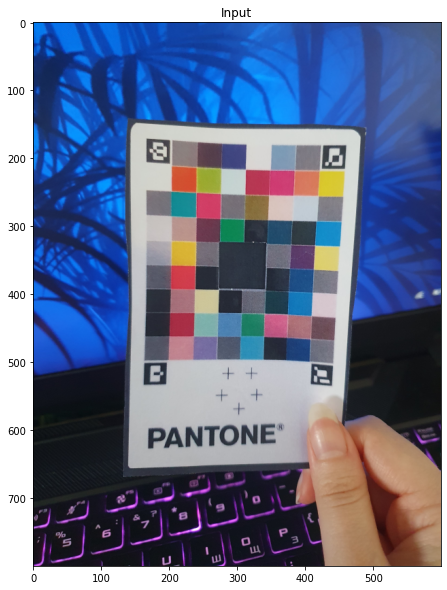

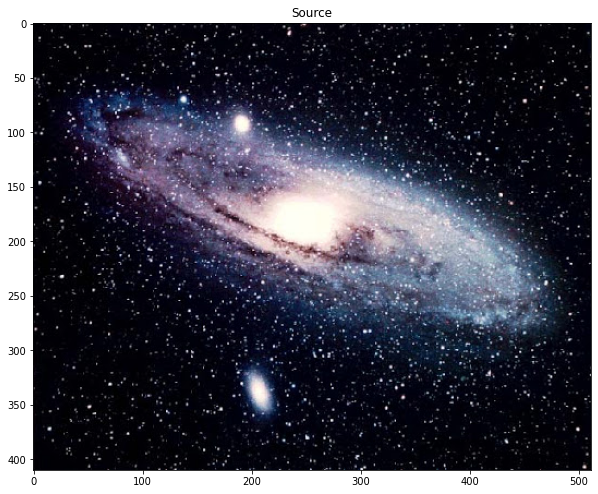

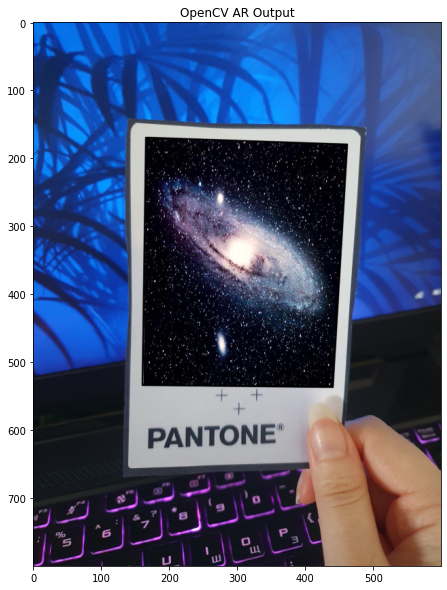

In [10]:
# показываем входное изображение, исходное изображение, выходное изображение с нашей дополненной реальностью
# show the input image, source image, output of our augmented reality
plt_imshow("Input", image)
plt_imshow("Source", source)
plt_imshow("OpenCV AR Output", output)